# Geographic Disparities in Education Access: Analysis Notebook
This notebook follows the workflow to analyze geographic disparities in education access across Sub-Saharan Africa using the `sub_saharan_africa.csv` dataset.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go


In [18]:
# Load the dataset
df = pd.read_csv('sub_saharan_africa.csv')
df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11216\3900669629.py:2: DtypeWarning:

Columns (7,14,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,iso_code,region_group,income_group,country,survey,year,level,grade,category,...,rlevel3_m,rlevel3_no,slevel3_m,slevel3_no,mlevel4_m,mlevel4_no,rlevel4_m,rlevel4_no,slevel4_m,slevel4_no
0,868,AGO,Sub-Saharan Africa,Lower middle income,Angola,DHS,2015,NaN,1,Location,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,869,AGO,Sub-Saharan Africa,Lower middle income,Angola,DHS,2015,NaN,1,Location,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,870,AGO,Sub-Saharan Africa,Lower middle income,Angola,DHS,2015,NaN,1,Location & Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,871,AGO,Sub-Saharan Africa,Lower middle income,Angola,DHS,2015,NaN,1,Location & Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,872,AGO,Sub-Saharan Africa,Lower middle income,Angola,DHS,2015,NaN,1,Location & Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning and Preparation
- Drop unnamed index columns
- Standardize country names
- Filter to 'Total' category and latest survey year
- Select key indicators: literacy_1524_m, comp_prim_v2_m, eduyears_2024_m

In [19]:
# Drop unnamed index column if exists
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Standardize country names (example)
df['country'] = df['country'].replace({"CÃÂ´te d'Ivoire": "Côte d'Ivoire"})

# Filter to total category
df_total = df[df['category'] == 'Total'].copy()

In [20]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 280 to 48502
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  316 non-null    object 
 1   region_group              316 non-null    object 
 2   income_group              316 non-null    object 
 3   country                   316 non-null    object 
 4   survey                    316 non-null    object 
 5   year                      316 non-null    int64  
 6   level                     83 non-null     object 
 7   grade                     316 non-null    int64  
 8   category                  316 non-null    object 
 9   sex                       0 non-null      object 
 10  location                  0 non-null      object 
 11  wealth                    0 non-null      object 
 12  region                    0 non-null      object 
 13  ethnicity                 0 non-null      object 
 14  religion   

In [21]:
# Drop columns where every entry is NaN (or None)
df_total.dropna(axis=1, how='all', inplace=True)


In [22]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 280 to 48502
Data columns (total 79 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  316 non-null    object 
 1   region_group              316 non-null    object 
 2   income_group              316 non-null    object 
 3   country                   316 non-null    object 
 4   survey                    316 non-null    object 
 5   year                      316 non-null    int64  
 6   level                     83 non-null     object 
 7   grade                     316 non-null    int64  
 8   category                  316 non-null    object 
 9   comp_prim_v2_m            228 non-null    float64
 10  comp_lowsec_v2_m          228 non-null    float64
 11  comp_upsec_v2_m           228 non-null    float64
 12  comp_prim_1524_m          108 non-null    float64
 13  comp_lowsec_1524_m        108 non-null    float64
 14  comp_upsec_

In [23]:

# Convert survey_year to numeric if needed
df_total['survey'] = pd.to_numeric(df_total['survey'], errors='coerce')
# Convert survey_year to numeric if needed
df_total['survey'] = pd.to_numeric(df_total['survey'], errors='coerce')

# Keep latest year per country
df_latest = df_total.sort_values('survey').groupby('iso_code').tail(1)

# Select key indicators
indicators = ['literacy_1524_m', 'comp_prim_v2_m', 'eduyears_2024_m']
df_selected = df_latest[['country', 'iso_code', 'survey'] + indicators].reset_index(drop=True)
df_selected.head()

,country,iso_code,survey,literacy_1524_m,comp_prim_v2_m,eduyears_2024_m
0,Angola,AGO,NaN,NaN,0.5987,NaN
1,Comoros,COM,NaN,NaN,0.4032,NaN
2,Equat. Guinea,GNQ,NaN,NaN,0.4223,NaN
3,South Sudan,SSD,NaN,NaN,0.2464,NaN
4,Eswatini,SWZ,NaN,NaN,0.7023,NaN


## Exploratory Data Analysis
Summary statistics for selected indicators.

In [24]:
# Summary statistics
df_selected[indicators].describe()

,literacy_1524_m,comp_prim_v2_m,eduyears_2024_m
count,5.000000,25.000000,8.000000
mean,0.682640,0.567500,6.112862
std,0.175918,0.185626,1.923239
min,0.497300,0.246400,3.170300
25%,0.533500,0.424000,4.981000
50%,0.682800,0.553200,6.906300
75%,0.774600,0.731400,7.424350
max,0.925000,0.932700,8.085800


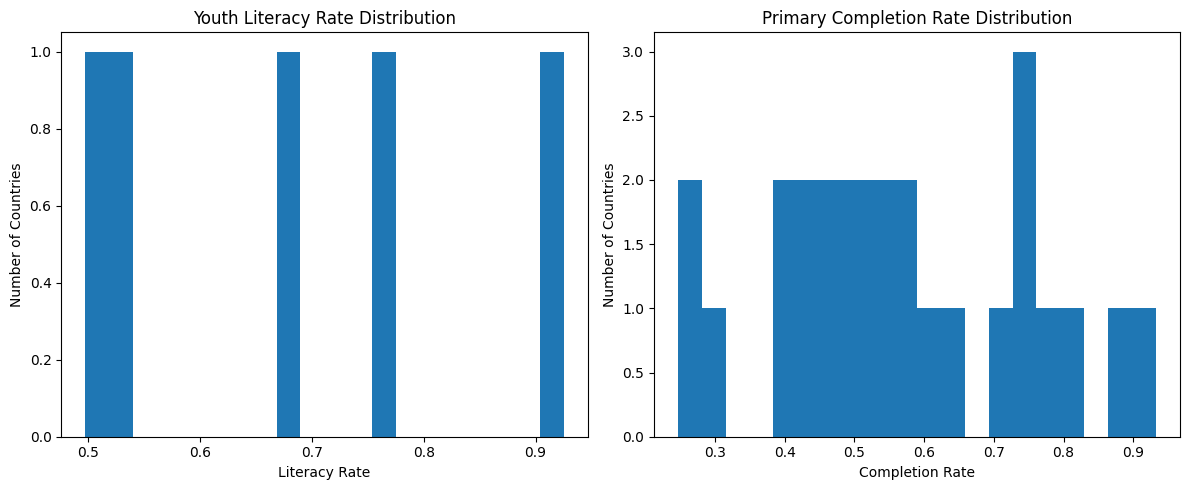

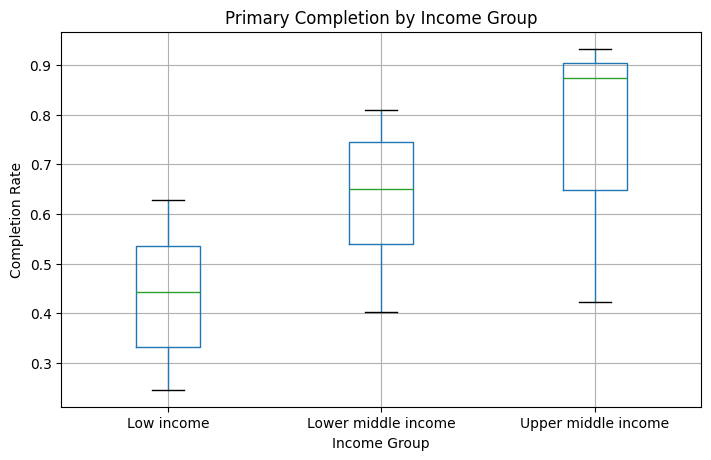

In [25]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(df_selected['literacy_1524_m'].dropna(), bins=20)
axes[0].set_title('Youth Literacy Rate Distribution')
axes[0].set_xlabel('Literacy Rate')
axes[0].set_ylabel('Number of Countries')

axes[1].hist(df_selected['comp_prim_v2_m'].dropna(), bins=20)
axes[1].set_title('Primary Completion Rate Distribution')
axes[1].set_xlabel('Completion Rate')
axes[1].set_ylabel('Number of Countries')

plt.tight_layout()
plt.show()

# Boxplot by income group if available
if 'income_group' in df_latest.columns:
    fig, ax = plt.subplots(figsize=(8, 5))
    df_latest.boxplot(column='comp_prim_v2_m', by='income_group', ax=ax)
    ax.set_title('Primary Completion by Income Group')
    ax.set_xlabel('Income Group')
    ax.set_ylabel('Completion Rate')
    plt.suptitle('')
    plt.show()

## Geospatial Visualization
Choropleth maps for literacy and primary completion rates.

In [26]:
# Choropleth map of youth literacy
fig = px.choropleth(
    df_selected,
    locations='iso_code',
    color='literacy_1524_m',
    hover_name='country',
    color_continuous_scale='Viridis',
    scope='africa',
    labels={'literacy_1524_m': 'Youth Literacy Rate'}
)
fig.update_layout(title_text='Youth Literacy Rate (15-24) by Country')
fig.show()

# Choropleth map of primary completion
fig2 = px.choropleth(
    df_selected,
    locations='iso_code',
    color='comp_prim_v2_m',
    hover_name='country',
    color_continuous_scale='Viridis',
    scope='africa',
    labels={'comp_prim_v2_m': 'Primary Completion Rate'}
)
fig2.update_layout(title_text='Primary Completion Rate by Country')
fig2.show()

## Cluster Analysis
Use K-means clustering on completion indicators.

In [27]:
# For clustering, include secondary completion if available
cluster_df = df_latest.set_index('iso_code')
features = ['comp_prim_v2_m']
for col in ['comp_lowsec_v2_m', 'comp_upsec_v2_m']:
    if col in cluster_df.columns:
        features.append(col)

X = cluster_df[features].dropna()
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_df.loc[X.index, 'cluster'] = kmeans.fit_predict(X)

# Plot cluster centers
centers = kmeans.cluster_centers_
fig = go.Figure(data=[
    go.Bar(name='Primary', x=['Cluster 0', 'Cluster 1', 'Cluster 2'], y=centers[:, 0]),
] +
[go.Bar(name=col.split('_v2_')[1].capitalize(), x=['Cluster 0', 'Cluster 1', 'Cluster 2'], y=centers[:, i])
 for i, col in enumerate(features[1:], start=1)])
fig.update_layout(barmode='group', title='Cluster Centers for Completion Rates')
fig.show()

## Interactive Dashboard Prototype (Plotly Dash)
Below is a minimal Dash app example to host maps and filters.

In [33]:
# Required imports
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Education Access in Sub-Saharan Africa"

# Sample data generation
def generate_sample_education_data():
    """Generate sample education data for Sub-Saharan African countries"""
    countries = [
        'Nigeria', 'Kenya', 'Uganda', 'Tanzania', 'Ghana', 'Ethiopia', 
        'Rwanda', 'Senegal', 'Mali', 'Burkina Faso', 'Niger', 'Chad',
        'South Africa', 'Botswana', 'Zambia', 'Zimbabwe', 'Malawi', 'Mozambique'
    ]
    
    iso_codes = [
        'NGA', 'KEN', 'UGA', 'TZA', 'GHA', 'ETH', 
        'RWA', 'SEN', 'MLI', 'BFA', 'NER', 'TCD',
        'ZAF', 'BWA', 'ZMB', 'ZWE', 'MWI', 'MOZ'
    ]
    
    np.random.seed(42)
    
    data = []
    for i, country in enumerate(countries):
        literacy_rate = np.random.uniform(30, 95)
        completion_rate = np.random.uniform(25, 90)
        
        data.append({
            'country': country,
            'iso_code': iso_codes[i],
            'literacy_1524_m': round(literacy_rate, 1),
            'comp_prim_v2_m': round(completion_rate, 1)
        })
    
    return pd.DataFrame(data)

# Generate sample data
df_selected = generate_sample_education_data()

# Z-PATTERN DASHBOARD LAYOUT
app.layout = html.Div([
    # TOP HORIZONTAL BAR (Z's top line) - Brand/Title + Key Stats
    html.Div([
        # Left: Brand/Title (Z's starting point)
        html.Div([
            html.H1(" EDUCATION ACCESS", 
                   style={'margin': '0', 'fontSize': '32px', 'fontWeight': '800', 'color': '#ffffff',
                         'textShadow': '2px 2px 4px rgba(0,0,0,0.3)'}),
            html.P("Sub-Saharan Africa Dashboard", 
                  style={'margin': '5px 0 0 0', 'fontSize': '16px', 'color': '#e8f4f8', 'fontWeight': '500'})
        ], style={'flex': '1'}),
        
        # Right: Key Statistics Cards (Z's top-right focus)
        html.Div([
            html.Div([
                html.Div([
                    html.H3("18", style={'margin': '0', 'color': '#ffffff', 'fontSize': '28px', 'fontWeight': '700'}),
                    html.P("Countries", style={'margin': '0', 'fontSize': '12px', 'color': '#e8f4f8'})
                ], style={'textAlign': 'center', 'padding': '15px 20px', 'backgroundColor': 'rgba(255,255,255,0.2)', 
                         'borderRadius': '15px', 'backdropFilter': 'blur(10px)', 'margin': '0 10px',
                         'border': '1px solid rgba(255,255,255,0.3)'}),
                
                html.Div([
                    html.H3("2024", style={'margin': '0', 'color': '#ffffff', 'fontSize': '28px', 'fontWeight': '700'}),
                    html.P("Latest Data", style={'margin': '0', 'fontSize': '12px', 'color': '#e8f4f8'})
                ], style={'textAlign': 'center', 'padding': '15px 20px', 'backgroundColor': 'rgba(46,204,113,0.3)', 
                         'borderRadius': '15px', 'backdropFilter': 'blur(10px)', 'margin': '0 10px',
                         'border': '1px solid rgba(46,204,113,0.5)'})
            ], style={'display': 'flex', 'alignItems': 'center'})
        ], style={'display': 'flex', 'alignItems': 'center'})
    ], style={
        'background': 'linear-gradient(135deg, #667eea 0%, #764ba2 100%)',
        'padding': '25px 40px', 'display': 'flex', 'alignItems': 'center', 'justifyContent': 'space-between',
        'boxShadow': '0 8px 32px rgba(0,0,0,0.15)', 'position': 'relative'
    }),
    
    # MAIN CONTENT AREA
    html.Div([
        # UPPER SECTION: Control Panel (left) + Summary Stats (right)
        html.Div([
            # LEFT: Interactive Controls (Z's diagonal starting point)
            html.Div([
                html.Div([
                    html.H2(" VISUALIZATION CONTROLS", 
                           style={'margin': '0 0 25px 0', 'fontSize': '22px', 'color': '#2c3e50',
                                 'textAlign': 'center', 'fontWeight': '700'}),
                    
                    # Indicator Selection Card
                    html.Div([
                        html.Label(" Select Education Indicator", 
                                  style={'fontWeight': '700', 'color': '#34495e', 'marginBottom': '12px', 
                                        'display': 'block', 'fontSize': '16px'}),
                        dcc.Dropdown(
                            id='indicator-dropdown',
                            options=[
                                {'label': ' Youth Literacy Rate (15-24 years)', 'value': 'literacy_1524_m'},
                                {'label': ' Primary School Completion Rate', 'value': 'comp_prim_v2_m'}
                            ],
                            value='literacy_1524_m',
                            style={'marginBottom': '20px', 'borderRadius': '12px', 'fontSize': '14px'}
                        )
                    ], style={
                        'background': 'linear-gradient(135deg, #f8f9fa 0%, #e9ecef 100%)', 
                        'padding': '20px', 'borderRadius': '15px', 'marginBottom': '20px',
                        'border': '2px solid #dee2e6', 'boxShadow': '0 4px 15px rgba(0,0,0,0.08)'
                    }),
                    
                    # Quick Stats Card
                    html.Div(id='quick-stats', style={
                        'background': 'linear-gradient(135deg, #667eea 0%, #764ba2 100%)',
                        'padding': '25px', 'borderRadius': '15px', 'color': 'white',
                        'boxShadow': '0 8px 25px rgba(102,126,234,0.3)',
                        'textAlign': 'center'
                    })
                ], style={
                    'background': 'rgba(255,255,255,0.95)', 'padding': '30px', 'borderRadius': '20px',
                    'boxShadow': '0 12px 40px rgba(0,0,0,0.1)', 'backdropFilter': 'blur(10px)',
                    'border': '1px solid rgba(255,255,255,0.3)'
                })
            ], style={'width': '35%', 'marginRight': '3%'}),
            
            # RIGHT: Key Insights Panel (Z's top-right destination)
            html.Div([
                html.Div([
                    html.H2(" KEY INSIGHTS", 
                           style={'margin': '0 0 20px 0', 'fontSize': '22px', 'color': '#2c3e50',
                                 'textAlign': 'center', 'fontWeight': '700'}),
                    html.Div(id='insights-panel')
                ], style={
                    'background': 'rgba(255,255,255,0.95)', 'padding': '30px', 'borderRadius': '20px',
                    'boxShadow': '0 12px 40px rgba(0,0,0,0.1)', 'backdropFilter': 'blur(10px)',
                    'border': '1px solid rgba(255,255,255,0.3)', 'height': '400px'
                })
            ], style={'width': '62%'})
        ], style={'display': 'flex', 'marginBottom': '30px'}),
        
        # LOWER SECTION: Main Visualization (Z's bottom line - diagonal destination to final focus)
        html.Div([
            html.Div([
                html.H2(" INTERACTIVE MAP VISUALIZATION", 
                       style={'margin': '0 0 25px 0', 'fontSize': '24px', 'color': '#2c3e50',
                             'textAlign': 'center', 'fontWeight': '700'}),
                dcc.Graph(id='choropleth-map', style={'height': '500px'})
            ], style={
                'background': 'rgba(255,255,255,0.95)', 'padding': '30px', 'borderRadius': '20px',
                'boxShadow': '0 12px 40px rgba(0,0,0,0.1)', 'backdropFilter': 'blur(10px)',
                'border': '1px solid rgba(255,255,255,0.3)'
            })
        ], style={'marginBottom': '30px'})
        
    ], style={'padding': '30px'})
    
], style={
    'fontFamily': '"Segoe UI", Tahoma, Geneva, Verdana, sans-serif',
    'background': 'linear-gradient(135deg, #667eea 0%, #764ba2 50%, #f093fb 100%)',
    'minHeight': '100vh',
    'position': 'relative'
})

# Callback for the choropleth map
@app.callback(
    Output('choropleth-map', 'figure'),
    Input('indicator-dropdown', 'value')
)
def update_map(indicator):
    # Create the choropleth map
    fig = px.choropleth(
        df_selected,
        locations='iso_code',
        color=indicator,
        hover_name='country',
        hover_data={indicator: ':.1f'},
        color_continuous_scale='Viridis',
        scope='africa',
        labels={indicator: indicator.replace('_', ' ').title()}
    )
    
    # Update layout for modern styling
    fig.update_layout(
        title_text=f'{indicator.replace("_", " ").title()} by Country',
        title_font_size=18,
        title_font_family="Segoe UI",
        title_font_color='#2c3e50',
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type='natural earth'
        ),
        plot_bgcolor='rgba(255,255,255,0.9)',
        paper_bgcolor='rgba(255,255,255,0.9)',
        font=dict(family="Segoe UI", size=12)
    )
    
    return fig

# Callback for quick stats
@app.callback(
    Output('quick-stats', 'children'),
    Input('indicator-dropdown', 'value')
)
def update_quick_stats(indicator):
    indicator_name = "Youth Literacy Rate" if indicator == 'literacy_1524_m' else "Primary Completion Rate"
    avg_value = df_selected[indicator].mean()
    max_country = df_selected.loc[df_selected[indicator].idxmax(), 'country']
    min_country = df_selected.loc[df_selected[indicator].idxmin(), 'country']
    
    return html.Div([
        html.H3(" QUICK STATISTICS", 
               style={'margin': '0 0 20px 0', 'fontSize': '18px', 'fontWeight': '700', 'textAlign': 'center'}),
        html.Div([
            html.Div([
                html.H4(f"{avg_value:.1f}%", style={'margin': '0', 'fontSize': '24px', 'fontWeight': '700'}),
                html.P("Average Rate", style={'margin': '0', 'fontSize': '12px', 'opacity': '0.9'})
            ], style={'textAlign': 'center', 'marginBottom': '15px'}),
            html.Div([
                html.H4(max_country, style={'margin': '0', 'fontSize': '16px', 'fontWeight': '700'}),
                html.P("Highest Performing", style={'margin': '0', 'fontSize': '12px', 'opacity': '0.9'})
            ], style={'textAlign': 'center', 'marginBottom': '15px'}),
            html.Div([
                html.H4(min_country, style={'margin': '0', 'fontSize': '16px', 'fontWeight': '700'}),
                html.P("Needs Most Support", style={'margin': '0', 'fontSize': '12px', 'opacity': '0.9'})
            ], style={'textAlign': 'center'})
        ])
    ])

# Callback for insights panel
@app.callback(
    Output('insights-panel', 'children'),
    Input('indicator-dropdown', 'value')
)
def update_insights(indicator):
    if indicator == 'literacy_1524_m':
        insights = [
            " Literacy rates vary significantly across the region",
            " Several countries show impressive progress in youth education",
            " Rural-urban disparities remain a key challenge",
            " Gender gaps in literacy are narrowing but persist",
            " Investment in teacher training shows positive correlation"
        ]
        color_scheme = 'linear-gradient(135deg, #3498db, #2980b9)'
    else:
        insights = [
            " Primary completion rates show regional variation",
            " Economic factors strongly influence completion rates",
            " Infrastructure development correlates with better outcomes",
            "Community engagement programs show measurable impact",
            " Nutrition programs improve retention rates significantly"
        ]
        color_scheme = 'linear-gradient(135deg, #e67e22, #d35400)'
    
    insight_cards = []
    for i, insight in enumerate(insights):
        insight_cards.append(
            html.Div([
                html.P(insight, style={
                    'margin': '0', 'fontSize': '14px', 'fontWeight': '600', 
                    'color': 'white', 'textAlign': 'center'
                })
            ], style={
                'background': color_scheme,
                'padding': '15px', 'borderRadius': '12px', 'marginBottom': '10px',
                'boxShadow': '0 4px 15px rgba(0,0,0,0.1)',
                'transform': 'scale(1)', 'transition': 'transform 0.3s ease'
            })
        )
    
    return html.Div(insight_cards)

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8052)